In [53]:
import pandas as pd
import matplotlib.pyplot as plt
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, make_scorer
import random
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# 1) ML-решение

In [2]:
df = pd.read_csv('data/PPG_Dataset.csv')
X = df.drop(columns=['Label'])
y = df['Label']
df


,0,1,2,3,4,5,6,7,8,9,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,Label
0,-0.015552,0.016963,0.013575,0.027204,0.068154,0.129259,0.127915,0.345174,0.197811,0.167651,...,-0.426464,-0.346976,-0.132168,-0.252098,-0.241969,-0.134235,-0.091327,-0.081713,-0.057693,MI
1,0.002323,0.002754,0.022539,0.228807,0.107751,0.034439,0.086007,0.155667,0.163327,0.223759,...,-0.169345,-0.356808,-0.338996,-0.292489,-0.152872,-0.156076,-0.103265,-0.041579,-0.044272,MI
2,0.050481,-0.339781,0.265111,0.045092,0.040086,0.087173,0.092814,0.099586,-0.143305,0.164186,...,-0.401426,-0.402333,-0.373426,-0.303710,0.008599,-0.180633,-0.143135,-0.084758,0.060668,MI
3,0.023882,0.016561,0.248547,0.054567,0.128032,0.085954,0.107359,0.207137,0.174547,-0.100118,...,-0.390700,-0.353882,-0.294014,-0.267005,-0.242258,-0.186946,-0.173718,0.101331,0.063555,MI
4,-0.058591,0.171551,0.057262,0.270869,0.138357,0.078509,0.062504,0.104447,0.134795,0.194248,...,-0.391598,-0.334490,-0.326873,-0.249881,-0.210052,-0.194763,-0.415365,0.015432,0.010321,MI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2571,-0.324640,-0.002758,0.032419,0.064355,0.058884,0.084295,0.113157,0.099573,0.161287,0.182989,...,-0.457989,-0.355685,-0.107379,-0.229693,-0.177197,-0.203492,-0.128723,-0.024295,-0.045567,MI
2572,0.237585,0.061030,0.072820,0.031893,0.114808,0.062936,0.307315,0.126924,0.392320,0.195136,...,-0.437642,-0.321945,-0.303451,-0.197557,-0.229486,-0.134217,-0.119387,-0.000022,-0.027357,MI
2573,0.016238,0.042248,0.042416,0.056881,0.058588,0.108145,0.095167,0.126091,0.163083,0.153061,...,-0.250780,-0.158280,-0.141116,-0.155825,-0.117786,-0.063283,-0.056181,-0.053293,0.007894,Normal
2574,0.002446,0.052906,0.050302,0.066125,0.052302,0.058444,0.048659,0.131709,0.129861,0.172007,...,-0.437347,-0.297214,-0.312739,-0.241026,-0.204217,-0.147206,-0.052625,-0.054537,0.006880,MI


In [3]:
y.value_counts()

MI        1294
Normal    1282
Name: Label, dtype: int64

### Построим графики нескольких сэмплов

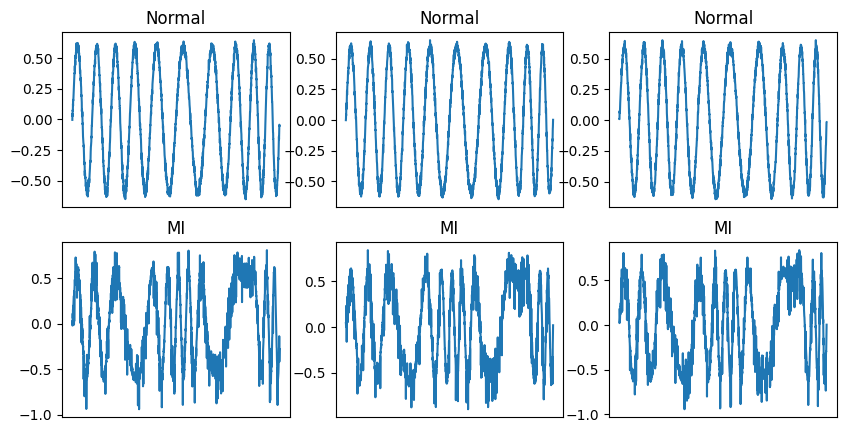

In [75]:
normal_indices = random.sample(set(df[df['Label'] == 'Normal'].index), 3)
mi_indices = random.sample(set(df[df['Label'] == 'MI'].index), 3)

fig, axes = plt.subplots(2, 3, figsize=(10, 5))
for i in range(3):
    axes[0, i].plot(X.loc[normal_indices[i]])
    axes[0, i].set_title('Normal')
    axes[0, i].set_xticks([])

for i in range(3):
    axes[1, i].plot(X.loc[mi_indices[i]])
    axes[1, i].set_title('MI')
    axes[1, i].set_xticks([])
# axes[1].plot(X.loc[2574])
# axes[1].set_title('MI')
plt.show()

### Выделим некоторые признаки из рядов показаний с помощью TSfresh

In [11]:
def reshape_to_long_format(data):
    long_data = []
    for i, row in data.iterrows():
        for t, value in enumerate(row):
            long_data.append([i, t, value])
    return pd.DataFrame(long_data, columns=['id', 'time', 'value'])

long_data = reshape_to_long_format(X)

In [12]:
long_data.shape

(5152000, 3)

In [13]:
long_data

,id,time,value
0,0,0,-0.015552
1,0,1,0.016963
2,0,2,0.013575
3,0,3,0.027204
4,0,4,0.068154
...,...,...,...
5151995,2575,1995,-0.121540
5151996,2575,1996,-0.106121
5151997,2575,1997,-0.098251
5151998,2575,1998,-0.027523


In [14]:
# extracted_features = extract_features(long_data, column_id='id', column_sort='time')

extracted_features = pd.read_csv('data/extracted_features.csv')

impute(extracted_features)

Feature Extraction: 100%|██████████| 30/30 [32:41<00:00, 65.37s/it]  
/home/alex/.local/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


   value__variance_larger_than_standard_deviation  value__has_duplicate_max  \
0                                             0.0                       0.0   
1                                             0.0                       0.0   
2                                             0.0                       0.0   
3                                             0.0                       0.0   
4                                             0.0                       0.0   

   value__has_duplicate_min  value__has_duplicate  value__sum_values  \
0                       0.0                   0.0          31.157460   
1                       0.0                   0.0          35.008497   
2                       0.0                   0.0          29.853268   
3                       0.0                   0.0          37.000555   
4                       0.0                   0.0          29.006665   

   value__abs_energy  value__mean_abs_change  value__mean_change  \
0         385.945107    

In [15]:
extracted_features

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,value__mean_n_absolute_max__number_of_maxima_7
0,0.0,0.0,0.0,0.0,31.157460,385.945107,0.076815,-0.000021,-2.126089e-06,0.033323,...,0.170467,0.170467,0.226363,1.783547,3.131116,4.628247,6.104146,7.001843,0.0,0.891275
1,0.0,0.0,0.0,0.0,35.008497,383.544686,0.077898,-0.000023,-7.819507e-07,0.040070,...,0.170467,0.170467,0.226363,1.783283,3.131496,4.639577,6.123029,7.020989,0.0,0.909372
2,0.0,0.0,0.0,0.0,29.853268,390.247977,0.078017,0.000005,1.340559e-04,0.038146,...,0.170467,0.170467,0.226363,1.784719,3.122319,4.604906,6.061805,6.984226,0.0,0.908856
3,0.0,0.0,0.0,0.0,37.000555,389.517027,0.075757,0.000020,-7.621493e-06,0.038695,...,0.136002,0.181214,0.226363,1.782757,3.130776,4.633616,6.100513,7.031413,0.0,0.903145
4,0.0,0.0,0.0,0.0,29.006665,387.874149,0.085458,0.000034,-5.887202e-05,0.021362,...,0.170467,0.170467,0.226363,1.786521,3.148947,4.677288,6.209533,7.121694,0.0,0.914211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2571,0.0,0.0,0.0,0.0,36.931273,385.777835,0.072992,0.000140,-8.587428e-05,0.038798,...,0.170467,0.170467,0.226363,1.782007,3.119638,4.611725,6.075621,6.965655,0.0,0.901361
2572,0.0,0.0,0.0,0.0,42.933851,390.687883,0.072834,-0.000133,3.734259e-05,0.024034,...,0.170467,0.170467,0.226363,1.783729,3.129227,4.623480,6.098806,6.995068,0.0,0.910804
2573,0.0,0.0,0.0,0.0,7.382986,360.821740,0.025227,-0.000004,8.803149e-06,0.011706,...,0.090729,0.136002,0.181214,1.770969,3.010773,4.286397,5.440401,6.222825,0.0,0.640998
2574,0.0,0.0,0.0,0.0,35.077470,393.101834,0.069541,0.000002,2.741952e-06,0.033762,...,0.170467,0.170467,0.226363,1.785916,3.140878,4.649605,6.108666,7.019329,0.0,0.895698


In [16]:
# extracted_features.to_csv('data/extracted_features.csv')

In [ ]:
cols_to_drop = list(extracted_features.columns[(extracted_features==0).all()])
extracted_features = extracted_features.drop(columns=cols_to_drop)

In [27]:
extracted_features

,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,value__mean,value__length,value__standard_deviation,...,value__fourier_entropy__bins_3,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__mean_n_absolute_max__number_of_maxima_7
0,0.0,31.157460,385.945107,0.076815,-0.000021,-2.126089e-06,0.033323,0.015579,2000.0,0.439010,...,0.079983,0.170467,0.170467,0.226363,1.783547,3.131116,4.628247,6.104146,7.001843,0.891275
1,0.0,35.008497,383.544686,0.077898,-0.000023,-7.819507e-07,0.040070,0.017504,2000.0,0.437568,...,0.079983,0.170467,0.170467,0.226363,1.783283,3.131496,4.639577,6.123029,7.020989,0.909372
2,0.0,29.853268,390.247977,0.078017,0.000005,1.340559e-04,0.038146,0.014927,2000.0,0.441476,...,0.079983,0.170467,0.170467,0.226363,1.784719,3.122319,4.604906,6.061805,6.984226,0.908856
3,0.0,37.000555,389.517027,0.075757,0.000020,-7.621493e-06,0.038695,0.018500,2000.0,0.440927,...,0.079983,0.136002,0.181214,0.226363,1.782757,3.130776,4.633616,6.100513,7.031413,0.903145
4,0.0,29.006665,387.874149,0.085458,0.000034,-5.887202e-05,0.021362,0.014503,2000.0,0.440144,...,0.079983,0.170467,0.170467,0.226363,1.786521,3.148947,4.677288,6.209533,7.121694,0.914211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2571,0.0,36.931273,385.777835,0.072992,0.000140,-8.587428e-05,0.038798,0.018466,2000.0,0.438803,...,0.079983,0.170467,0.170467,0.226363,1.782007,3.119638,4.611725,6.075621,6.965655,0.901361
2572,0.0,42.933851,390.687883,0.072834,-0.000133,3.734259e-05,0.024034,0.021467,2000.0,0.441456,...,0.079983,0.170467,0.170467,0.226363,1.783729,3.129227,4.623480,6.098806,6.995068,0.910804
2573,0.0,7.382986,360.821740,0.025227,-0.000004,8.803149e-06,0.011706,0.003691,2000.0,0.424732,...,0.090729,0.090729,0.136002,0.181214,1.770969,3.010773,4.286397,5.440401,6.222825,0.640998
2574,0.0,35.077470,393.101834,0.069541,0.000002,2.741952e-06,0.033762,0.017539,2000.0,0.442994,...,0.079983,0.170467,0.170467,0.226363,1.785916,3.140878,4.649605,6.108666,7.019329,0.895698


### Обучим Random Forest на извлеченных признаках и посмотрим на результаты кросс-валидации

In [36]:
y = y.apply(lambda label: 1 if label == 'MI' else 0)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(extracted_features, y, test_size=0.2, random_state=42)

In [39]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Разбиение на train и test

In [41]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Вероятности для ROC-AUC

# Метрики качества
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9632
F1-Score: 0.9627
ROC-AUC: 0.9613

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       260
           1       0.97      0.96      0.96       256

    accuracy                           0.96       516
   macro avg       0.96      0.96      0.96       516
weighted avg       0.96      0.96      0.96       516



Кросс-валидация на 5 фолдах

In [47]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
}

cv_results = cross_validate(
    model,
    extracted_features,   
    y,  
    cv=5,  
    scoring=scoring,
    return_train_score=False 
)

print(f"Средняя Accuracy: {cv_results['test_accuracy'].mean():.4f}")
print(f"Средний F1-Score: {cv_results['test_f1'].mean():.4f}")
print(f"Средний ROC-AUC: {cv_results['test_roc_auc'].mean():.4f}")


# print("\nМетрики по фолдам:")
# for metric_name, metric_values in cv_results.items():
#     if metric_name.startswith('test_'):
#         print(f"{metric_name}: {metric_values}")

Средняя Accuracy: 0.9643
Средний F1-Score: 0.9636
Средний ROC-AUC: 0.9634


# 2) Пороговый классификатор